In [1]:
# This notebook is slow because I am processing through all the data from the 5 years, not one year. This notebook
# on the whole takes about 10 minutes to run. 
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gsw
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 4})

In [2]:
# We shall use the most recent model years, which at the moment is 1041 to 1045
rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
datadir = 'ocean_annual_z_1x1deg/ts/annual/5yr/'
filename_age = 'ocean_annual_z_1x1deg.1041-1045.agessc.nc'
filename_temp = 'ocean_annual_z_1x1deg.1041-1045.thetao.nc'
filename_vol = 'ocean_annual_z_1x1deg.1041-1045.volcello.nc'
filename_so = 'ocean_annual_z_1x1deg.1041-1045.so.nc'
datadir05 = 'ocean_annual_z/ts/annual/5yr/'
filename_temp05 = 'ocean_annual_z.1041-1045.thetao.nc'

In [3]:
def calc_sigmantr(T,S):
    '''function sigmantr = calc_sigmantr(T,S)
    CALCULATE APPROXIMATE NEUTRAL DENSITY FROM POTENTIAL TEMPERATURE AND SALINITY,
    using functional form of MacDougall and Jackett (2005)
    
    INPUT
        T    potential temperature in degrees celsius
        S    salinity in psu

    OUTPUT
        sigmantr    approximation of neutral density from empirical formula of MacDougall and Jackett (2005)

    Copied across from cdfsigntr.f90 from CDFTOOLS package by G.MacGilchrist (gmacgilchrist@gmail.com)'''
    
    dl_t = T;
    dl_s = S;
    dl_sr= np.sqrt(np.abs(dl_s));

    ### Numerator
    # T-polynome
    dl_r1=((-4.3159255086706703e-4*dl_t+8.1157118782170051e-2 )*dl_t+2.2280832068441331e-1 )*dl_t+1002.3063688892480e0;
    # S-T Polynome
    dl_r2=(-1.7052298331414675e-7*dl_s-3.1710675488863952e-3*dl_t-1.0304537539692924e-4)*dl_s;
    ### Denominator
    # T-Polynome
    dl_r3=(((-2.3850178558212048e-9*dl_t-1.6212552470310961e-7)*dl_t+7.8717799560577725e-5)*dl_t+4.3907692647825900e-5)*dl_t+1.0e0;
    # S-T Polynome
    dl_r4=((-2.2744455733317707e-9*dl_t*dl_t+6.0399864718597388e-6)*dl_t-5.1268124398160734e-4 )*dl_s;
    # S-T Polynome
    dl_r5=(-1.3409379420216683e-9*dl_t*dl_t-3.6138532339703262e-5)*dl_s*dl_sr;

    # Neutral density
    sigmantr = ( dl_r1 + dl_r2 ) / ( dl_r3 + dl_r4 + dl_r5 ) - 1000E0;
    
    return sigmantr

In [4]:
age = xr.open_dataset(rootdir + datadir + filename_age) # Ideal Age
temp = xr.open_dataset(rootdir + datadir + filename_temp) # Temperature
vol = xr.open_dataset(rootdir + datadir + filename_vol) #Volume
so = xr.open_dataset(rootdir + datadir + filename_so) #Salinity

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [5]:
# Calculate Neutral Density
neutralden = calc_sigmantr(temp.thetao, so.so)
neutralden.name = 'neutral_density'
# Calculate Potential Density
potden = gsw.density.sigma2(so.so, temp.thetao)
lat = so.lat 
lon = so.lon
time = so.time
z_l = so.z_l
pot_den = xr.DataArray(potden, coords = [time, z_l, lat, lon ], dims = ['time', 'z_l', 'lat', 'lon'])
pot_den.name = 'potential_density'

In [6]:
ds = xr.merge([temp, age, vol, so, neutralden, pot_den])

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/num

In [7]:
def weightedstd(ds,variable,weights):
    # variable and weights are strings
    M = ds[variable].size
    variable_times_weights = ds[variable]*ds[weights]
    weightedmean = variable_times_weights.sum()/ds[weights].sum()
    numerator = ds[weights]*(ds[variable]-weightedmean)**2
    numerator = numerator.sum()
    denominator = ((M-1)/M)*ds[weights].sum()
    weightedstd = numerator/denominator
    return weightedstd**(0.5)
def weightedmean(ds,variable,weights):
    # variable and weights are strings
    variable_times_weights = ds[variable]*ds[weights]
    weightedmean = variable_times_weights.sum()/ds[weights].sum()
    return weightedmean

In [8]:
def calculate(dataset, sort, bins, bin_label, var, w, bol):
    # dataset => dataset you use, sort => what are you grouping with, var => variable, w= weight, 
    # bol = a boolean, true = want weighted mean, false want weighted std)
    newdataset = dataset.groupby_bins(sort, bins, labels=bin_label)
    mean = newdataset.apply(weightedmean, variable = var, weights = w)
    wstd = newdataset.apply(weightedstd, variable = var, weights= w)
    if (bol == True):
        return mean
    else: 
        return wstd

In [9]:
def binsum(ds,variable):
    # variable and weights are strings
    variable_times_weights = ds[variable]
    volsum = variable_times_weights.sum()
    return volsum

In [10]:
def binplots(x, y, error, labely, labelx, year):
    plt.figure(figsize = (15,10))
    plt.errorbar(x, y, xerr = error, marker = 'o', linestyle = '--', markeredgecolor = 'r')
    plt.title('Average Age with respect to depth with volume weighted average for years ' + str(year) + ' to ' + str(year +4) )
    plt.gca().invert_yaxis() # Flips y axis, since depth of 0 is the ocean surface, but for comparison purposes we will not do that
    plt.ylabel(labely)
    plt.xlabel(labelx)
    plt.show()

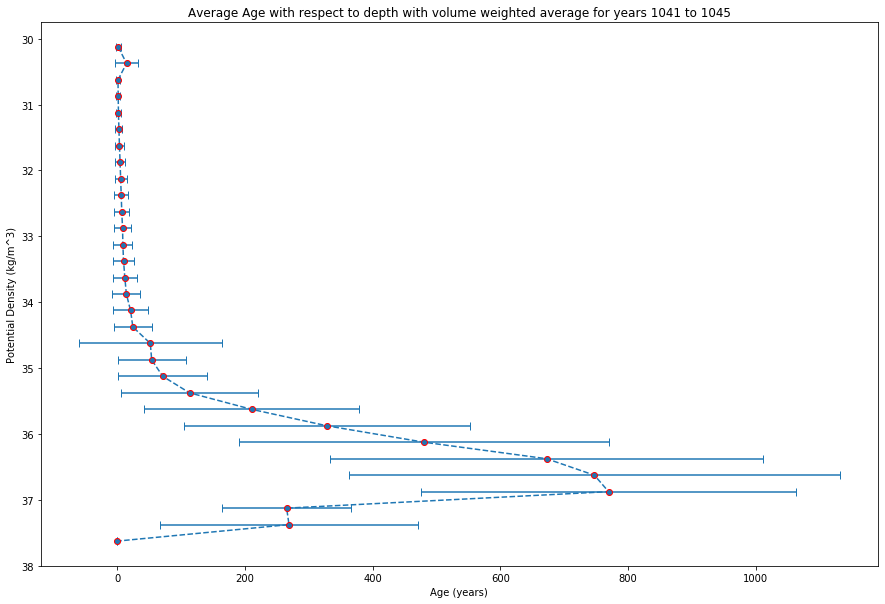

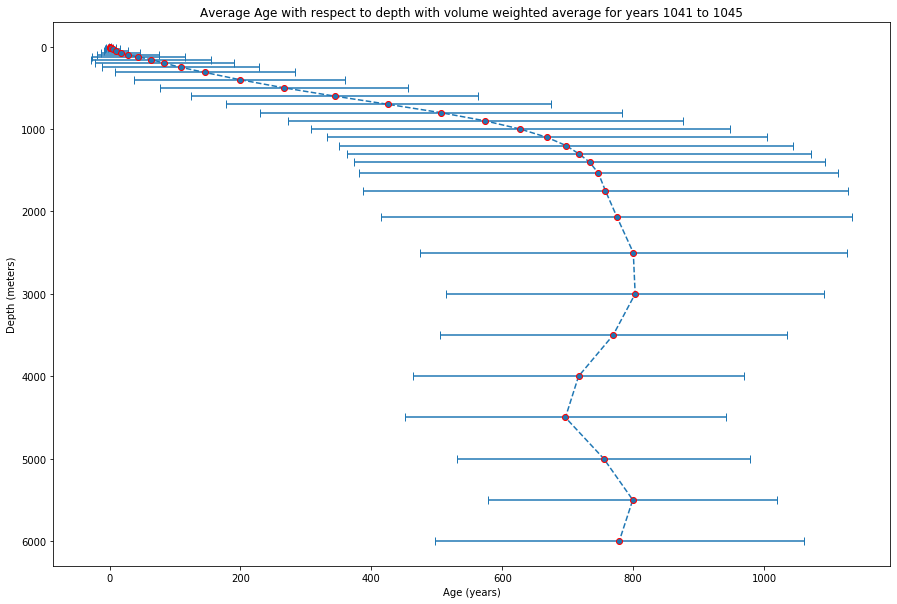

In [11]:
potden_bins = np.arange(30, 38, 0.25)
potden_bins_labels = np.arange(30.125,37.875, 0.25)
z_l = so.z_l
z_small = z_l[:34]
den_mean = calculate(ds, 'potential_density', potden_bins, potden_bins_labels, 'agessc', 'volcello', True)
den_wstd = calculate(ds, 'potential_density', potden_bins, potden_bins_labels, 'agessc', 'volcello', False)
dep_mean = calculate(ds, 'z_l', z_l, z_small, 'agessc', 'volcello', True)
dep_wstd = calculate(ds, 'z_l', z_l, z_small, 'agessc', 'volcello', False)
binplots(den_mean, potden_bins_labels, den_wstd, 'Potential Density (kg/m^3)', 'Age (years)', 1041)
binplots(dep_mean, z_small, dep_wstd, 'Depth (meters)', 'Age (years)', 1041)


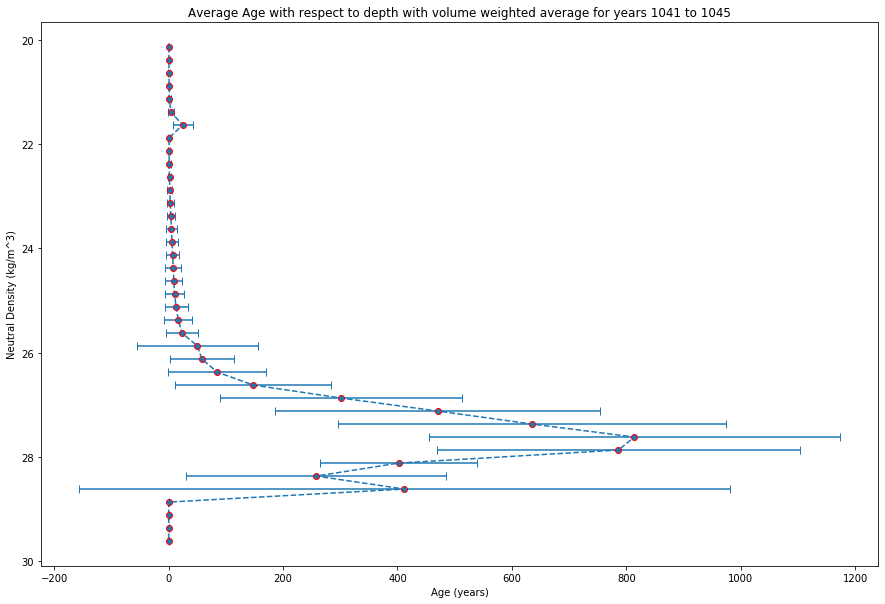

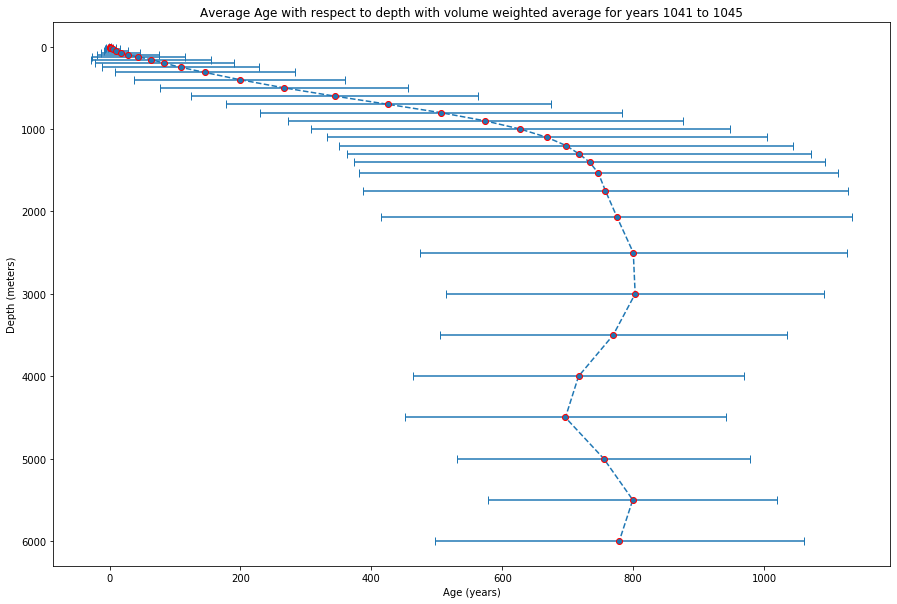

In [12]:
neutralden_bins = np.arange(20, 30, 0.25)
neutralden_bins_labels = np.arange(20.125, 29.875, 0.25)
nden_mean = calculate(ds, 'neutral_density', neutralden_bins, neutralden_bins_labels, 'agessc', 'volcello', True)
nden_wstd = calculate(ds, 'neutral_density', neutralden_bins, neutralden_bins_labels, 'agessc', 'volcello', False)
binplots(nden_mean, neutralden_bins_labels, nden_wstd, 'Neutral Density (kg/m^3)', 'Age (years)', 1041)
binplots(dep_mean, z_small, dep_wstd, 'Depth (meters)', 'Age (years)', 1041)

In [13]:
# Try to sum the volume in each depth class
newdataset = ds.isel(time=0).groupby_bins('z_l', z_l, labels=z_small)
newvolsum = newdataset.apply(binsum, variable = 'volcello')
print(newvolsum)

<xarray.DataArray 'volcello' (z_l_bins: 34)>
array([3.597804e+15, 3.571299e+15, 5.319067e+15, 7.893124e+15, 8.673288e+15,
       8.601215e+15, 8.546473e+15, 1.274540e+16, 1.688510e+16, 1.678815e+16,
       2.502205e+16, 3.311282e+16, 3.287469e+16, 3.267296e+16, 3.251051e+16,
       3.236681e+16, 3.222902e+16, 3.208871e+16, 3.195428e+16, 3.181551e+16,
       3.166363e+16, 3.151144e+16, 5.477598e+16, 7.738645e+16, 1.138534e+17,
       1.465380e+17, 1.366550e+17, 1.194837e+17, 9.498138e+16, 6.568930e+16,
       3.687958e+16, 1.234682e+16, 1.782443e+15, 1.918864e+14], dtype=float32)
Coordinates:
  * z_l_bins  (z_l_bins) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03
    time      object 1041-07-02 12:00:00


In [14]:
# Try to sum the volume in each neutral density class
different = ds.isel(time=0).groupby_bins('neutral_density',neutralden_bins, labels = neutralden_bins_labels)
denvolsum = different.apply(binsum, variable='volcello')
print(denvolsum)

<xarray.DataArray 'volcello' (neutral_density_bins: 39)>
array([1.255094e+13, 1.671287e+13, 3.113330e+13, 4.238900e+13, 7.424575e+13,
       1.330840e+14, 7.142215e+14, 6.298145e+14, 9.087474e+14, 1.043078e+15,
       1.155235e+15, 1.321005e+15, 1.310934e+15, 1.405084e+15, 1.413759e+15,
       1.623170e+15, 1.943468e+15, 2.326253e+15, 3.086504e+15, 3.579220e+15,
       4.337933e+15, 5.863582e+15, 8.061385e+15, 1.280698e+16, 2.022687e+16,
       3.964449e+16, 4.934756e+16, 4.532126e+16, 5.338136e+16, 6.619992e+16,
       1.586258e+17, 7.026422e+17, 1.319511e+17, 1.319580e+16, 3.546502e+14,
       6.433989e+11, 3.579751e+11, 5.366099e+11, 2.431120e+11], dtype=float32)
Coordinates:
  * neutral_density_bins  (neutral_density_bins) float64 20.12 20.38 ... 29.62
    time                  object 1041-07-02 12:00:00


In [15]:
# Try to sum the volume in each potential density class
dif = ds.isel(time=0).groupby_bins('potential_density',potden_bins, labels = potden_bins_labels)
potdenvolsum = dif.apply(binsum, variable='volcello')
print(potdenvolsum)

<xarray.DataArray 'volcello' (potential_density_bins: 31)>
array([7.686392e+14, 1.284198e+15, 9.218421e+14, 9.922994e+14, 1.155043e+15,
       1.142158e+15, 1.252310e+15, 1.185634e+15, 1.299691e+15, 1.522468e+15,
       1.831963e+15, 2.077513e+15, 2.744720e+15, 3.043086e+15, 3.681736e+15,
       4.553786e+15, 5.183621e+15, 7.564808e+15, 1.127890e+16, 1.773317e+16,
       2.754123e+16, 3.911352e+16, 4.100578e+16, 4.138330e+16, 4.985593e+16,
       8.044979e+16, 2.925724e+17, 6.361743e+17, 4.518552e+16, 9.468915e+15,
       6.514848e+11], dtype=float32)
Coordinates:
  * potential_density_bins  (potential_density_bins) float64 30.12 ... 37.62
    time                    object 1041-07-02 12:00:00


Text(0, 0.5, 'Depth bins')

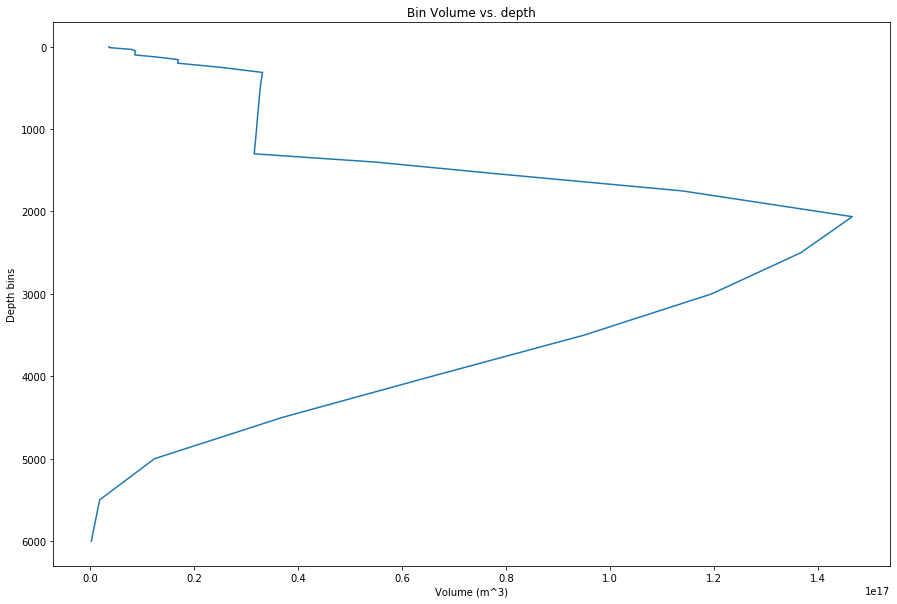

In [16]:
plt.figure(figsize = (15,10))
plt.plot(newvolsum, z_small)
plt.gca().invert_yaxis() 
plt.title('Bin Volume vs. depth')
plt.xlabel('Volume (m^3)')
plt.ylabel('Depth bins')

Text(0, 0.5, 'Neutral Density bins (kg/m^3)')

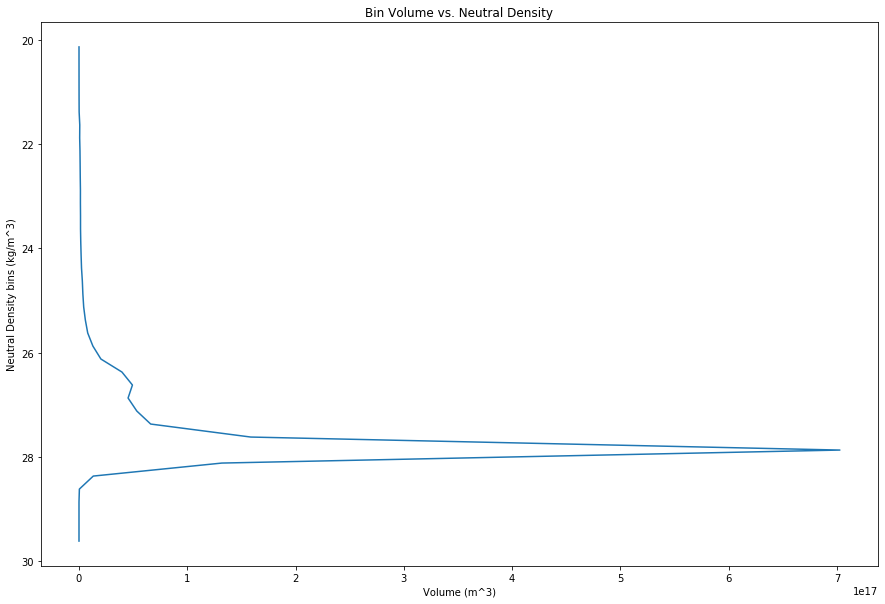

In [17]:
plt.figure(figsize = (15,10))
plt.plot(denvolsum, neutralden_bins_labels)
plt.gca().invert_yaxis() 
plt.title('Bin Volume vs. Neutral Density')
plt.xlabel('Volume (m^3)')
plt.ylabel('Neutral Density bins (kg/m^3)')

Text(0, 0.5, 'Potential Density bins (kg/m^3)')

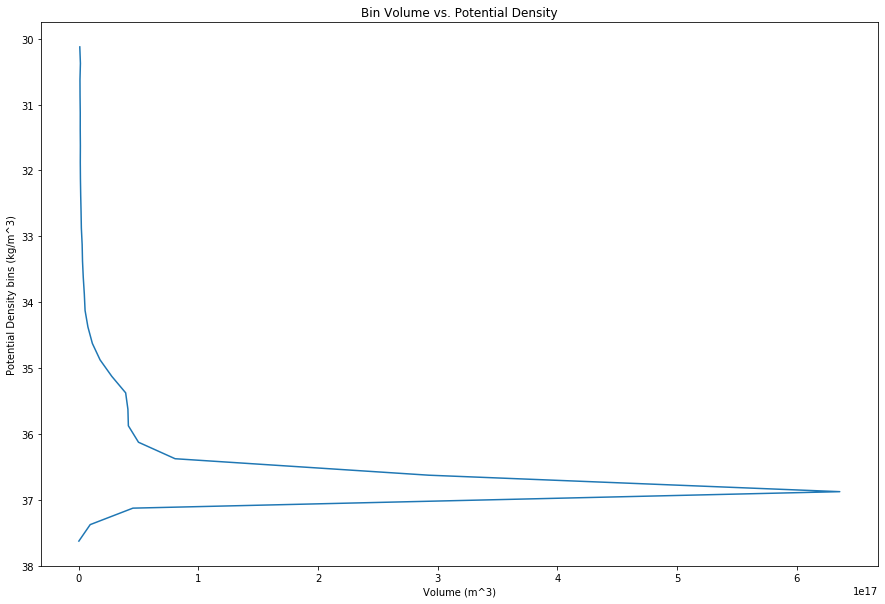

In [18]:
plt.figure(figsize = (15,10))
plt.plot(potdenvolsum, potden_bins_labels)
plt.gca().invert_yaxis() 
plt.title('Bin Volume vs. Potential Density')
plt.xlabel('Volume (m^3)')
plt.ylabel('Potential Density bins (kg/m^3)')

In [19]:
# We will now separate the Atlantic Basin from the Indian-Pacific Basin. 
atl = []
indopac= []
for i in range(0, 360):
    if (i < 30 or i > 285):
        atl.append(i)
    else:
        indopac.append(i)
atlantic = ds.isel(lon = atl)
indopacific = ds.isel(lon = indopac)

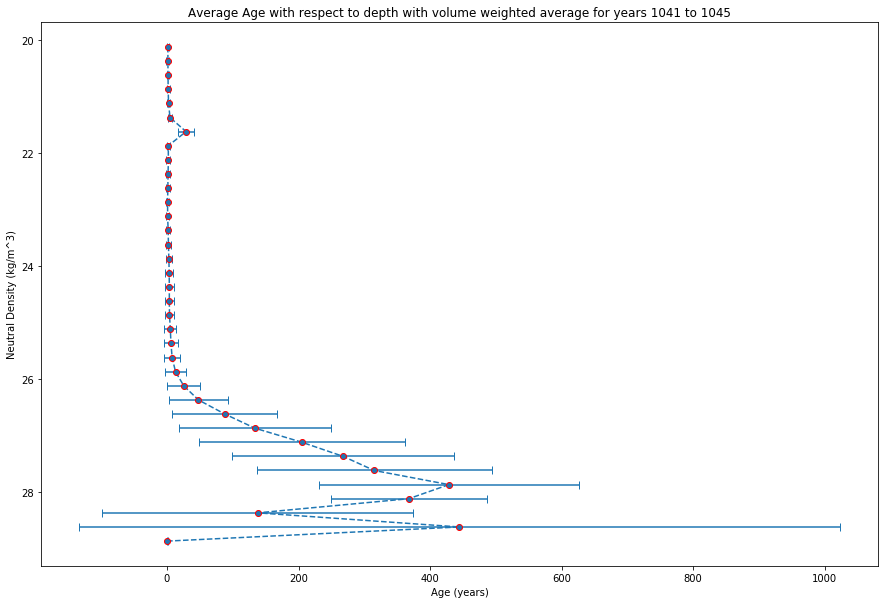

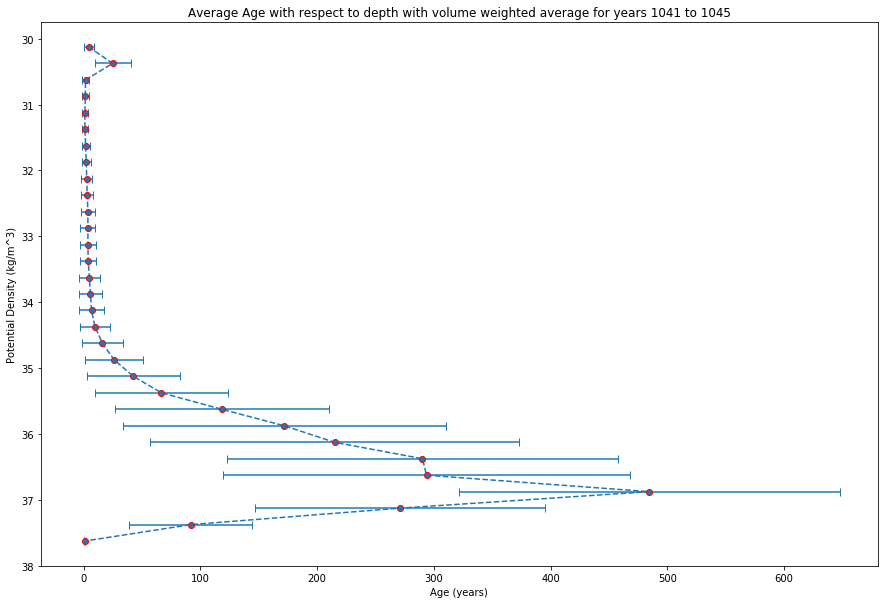

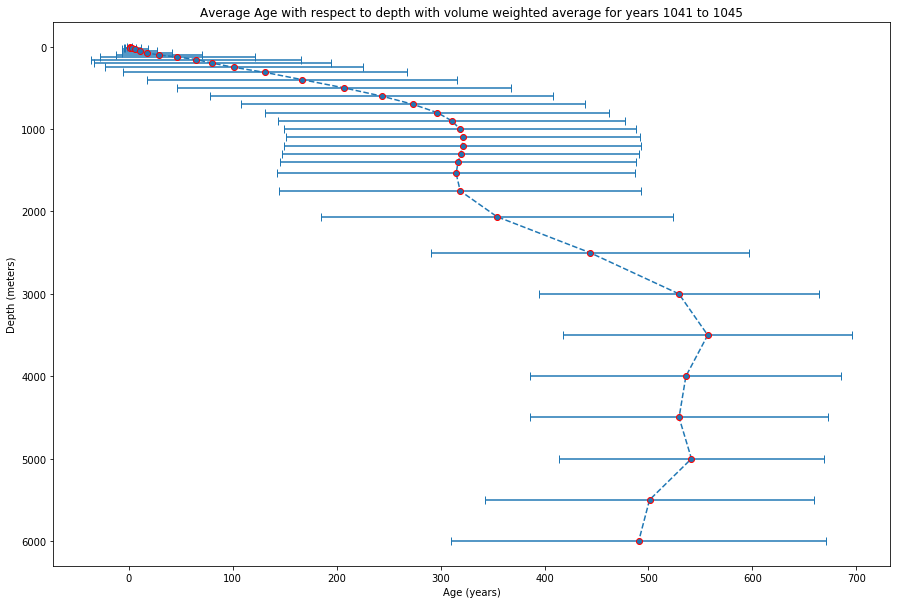

In [20]:
# Look at Atlantic average with potential density, neutral density, and depth
atlpotden_mean = calculate(atlantic, 'potential_density', potden_bins, potden_bins_labels, 'agessc', 'volcello', True)
atlpotden_wstd = calculate(atlantic, 'potential_density', potden_bins, potden_bins_labels, 'agessc', 'volcello', False)
# Depth
atldep_mean = calculate(atlantic, 'z_l', z_l, z_small, 'agessc', 'volcello', True)
atldep_wstd = calculate(atlantic, 'z_l', z_l, z_small, 'agessc', 'volcello', False)
# Neutral Density
atlnden_mean = calculate(atlantic, 'neutral_density', neutralden_bins, neutralden_bins_labels, 'agessc', 'volcello', True)
atlnden_wstd = calculate(atlantic, 'neutral_density', neutralden_bins, neutralden_bins_labels, 'agessc', 'volcello', False)
# Plotting each of them in the Atlantic
binplots(atlnden_mean, neutralden_bins_labels, atlnden_wstd, 'Neutral Density (kg/m^3)', 'Age (years)', 1041)
binplots(atlpotden_mean, potden_bins_labels, atlpotden_wstd, 'Potential Density (kg/m^3)', 'Age (years)', 1041)
binplots(atldep_mean, z_small, atldep_wstd, 'Depth (meters)', 'Age (years)', 1041)

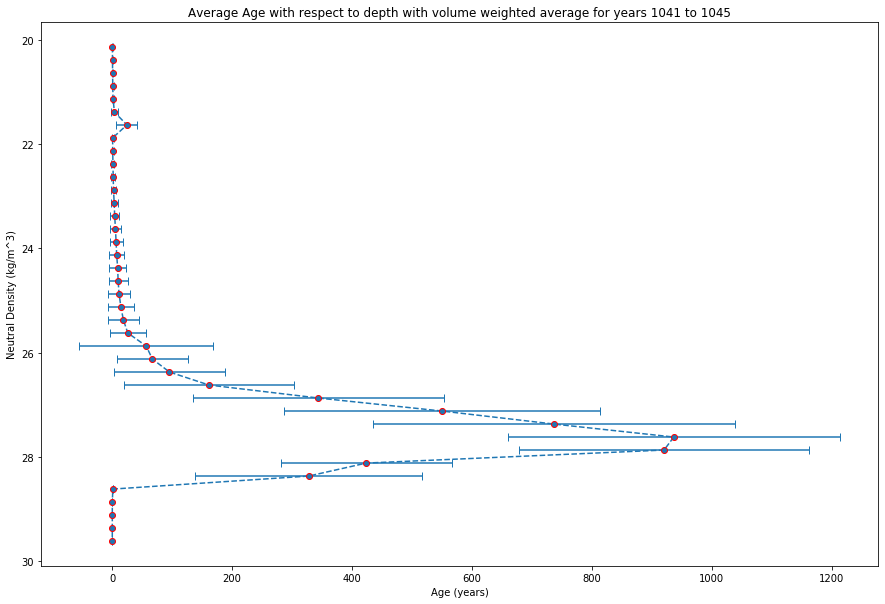

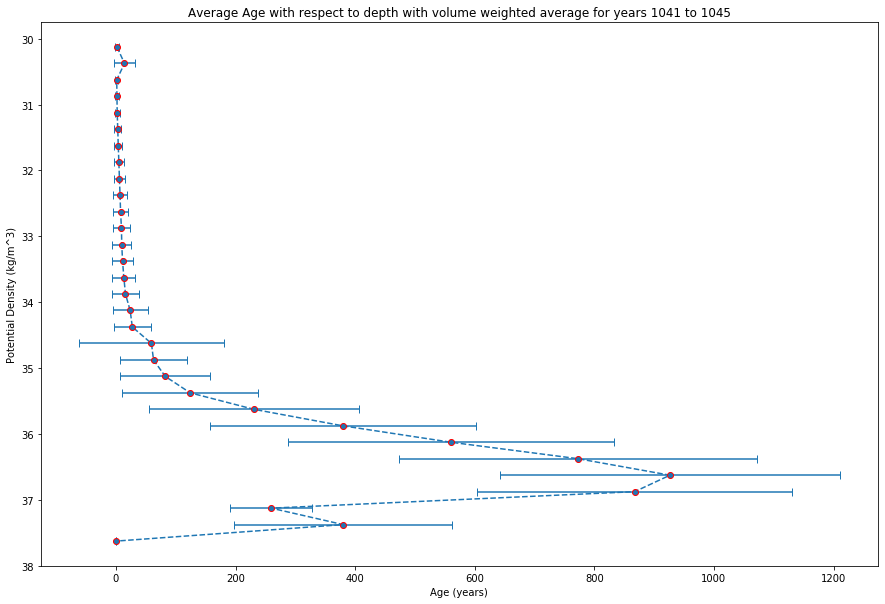

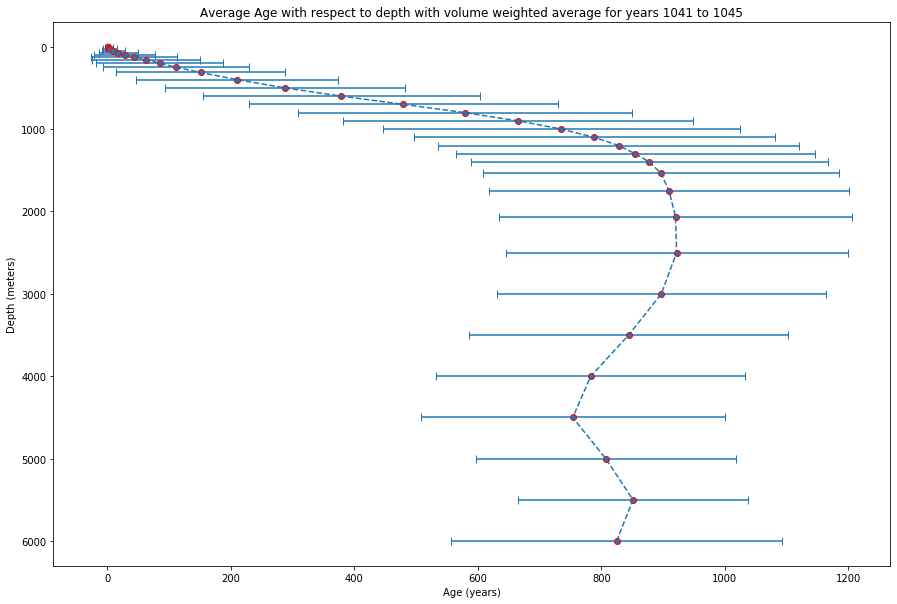

In [21]:
# Look at Indo-Pacific average with potential density, neutral density, and depth
indopacpotden_mean = calculate(indopacific, 'potential_density', potden_bins, potden_bins_labels, 'agessc', 'volcello', True)
indopacpotden_wstd = calculate(indopacific, 'potential_density', potden_bins, potden_bins_labels, 'agessc', 'volcello', False)
# Depth
indopacdep_mean = calculate(indopacific, 'z_l', z_l, z_small, 'agessc', 'volcello', True)
indopacdep_wstd = calculate(indopacific, 'z_l', z_l, z_small, 'agessc', 'volcello', False)
# Neutral Density
indopacnden_mean = calculate(indopacific, 'neutral_density', neutralden_bins, neutralden_bins_labels, 'agessc', 'volcello', True)
indopacnden_wstd = calculate(indopacific, 'neutral_density', neutralden_bins, neutralden_bins_labels, 'agessc', 'volcello', False)
# Plotting each of them in the Indo-Pacific
binplots(indopacnden_mean, neutralden_bins_labels, indopacnden_wstd, 'Neutral Density (kg/m^3)', 'Age (years)', 1041)
binplots(indopacpotden_mean, potden_bins_labels, indopacpotden_wstd, 'Potential Density (kg/m^3)', 'Age (years)', 1041)
binplots(indopacdep_mean, z_small, indopacdep_wstd, 'Depth (meters)', 'Age (years)', 1041)

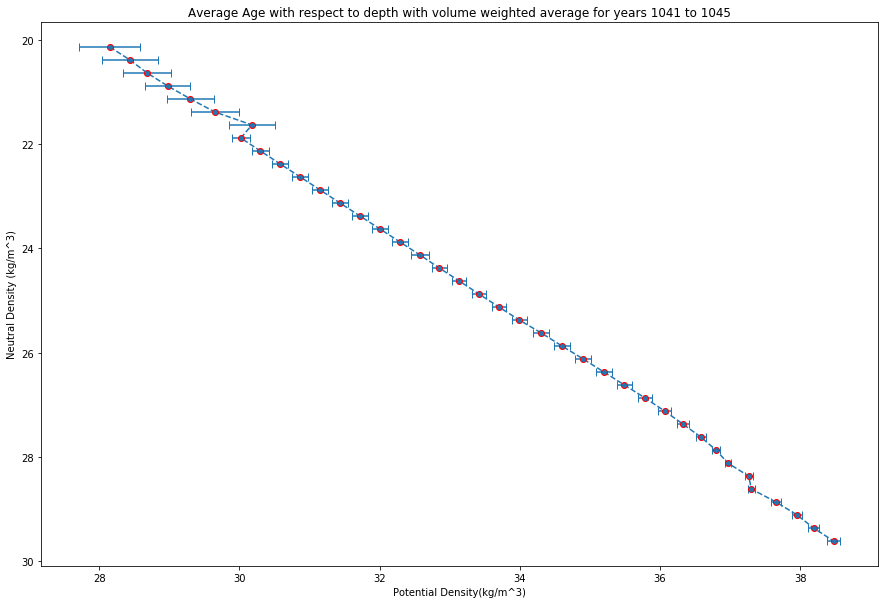

In [22]:
# Let's compare neutral density and potential density!!! 
potnden_mean = calculate(ds, 'neutral_density', neutralden_bins, neutralden_bins_labels, 'potential_density', 'volcello', True)
potnden_wstd = calculate(ds, 'neutral_density', neutralden_bins, neutralden_bins_labels, 'potential_density', 'volcello', False)
binplots(potnden_mean, neutralden_bins_labels, potnden_wstd, 'Neutral Density (kg/m^3)', 'Potential Density(kg/m^3)', 1041)

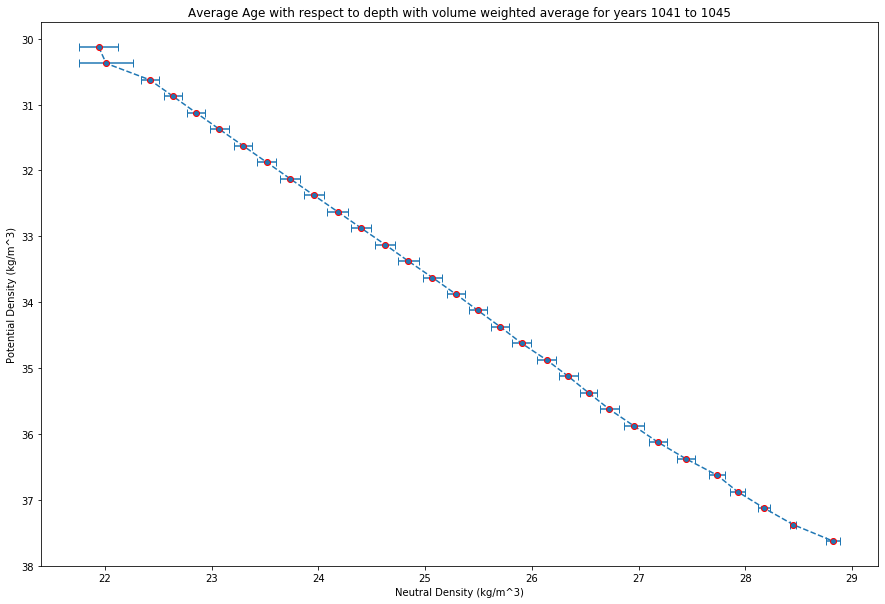

In [23]:
npotden_mean = calculate(ds, 'potential_density', potden_bins, potden_bins_labels, 'neutral_density', 'volcello', True)
npotden_wstd = calculate(ds, 'potential_density', potden_bins, potden_bins_labels, 'neutral_density', 'volcello', False)
binplots(npotden_mean, potden_bins_labels, npotden_wstd, 'Potential Density (kg/m^3)', 'Neutral Density (kg/m^3)', 1041)

In [24]:
# here are some plots of depth with respect to age. 
plotting = np.asarray(ds.agessc[0])
volle = np.asarray(ds.volcello[0])
deptharray = np.array(ds.z_l)
def depthageplots(age, volume, depth, val, val2):
    depthplot = np.full([180, 360], 0)
    volplot = np.full([180, 360], 0)
    for i in range(0, 35):
        for j in range(0, 180):
            for k in range(0, 360):
                a = age[i][j][k]
                b = volume[i][j][k]
                if (a < val2 and a > val):
                    depthplot[j][k] += depth[i]*b
                    volplot[j][k] += b
    # Let's see if this works
    refplot = depthplot/volplot
    plt.figure(figsize = (15,10))
    im = plt.pcolormesh(lon, lat, refplot)
    cbar = plt.colorbar(im)
    cbar.set_label('Depth (meters)', rotation = 270, labelpad=16)
    plt.title('Average depth of Ideal age contours between ' + str(val) + ' and ' + str(val2) + ' in year 1041')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


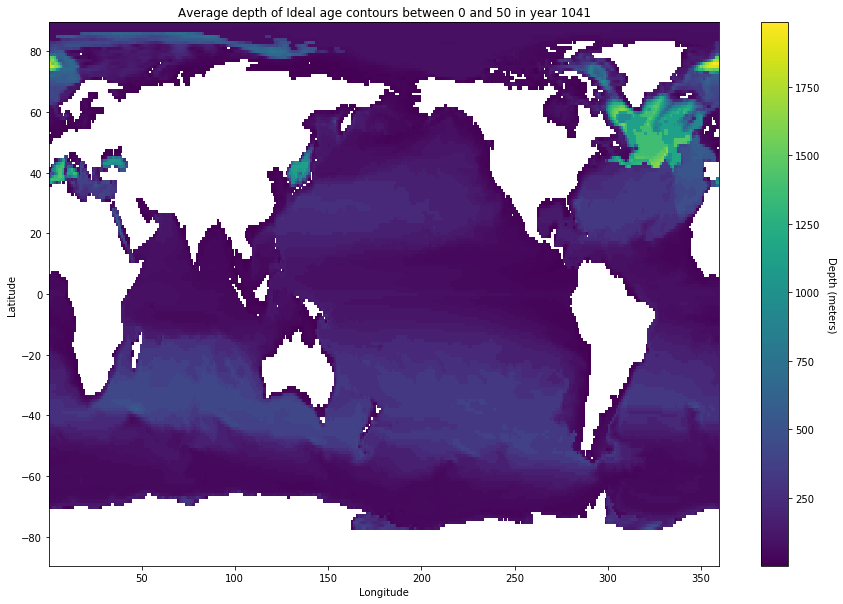

In [25]:
depthageplots(plotting, volle, deptharray, 0, 50)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


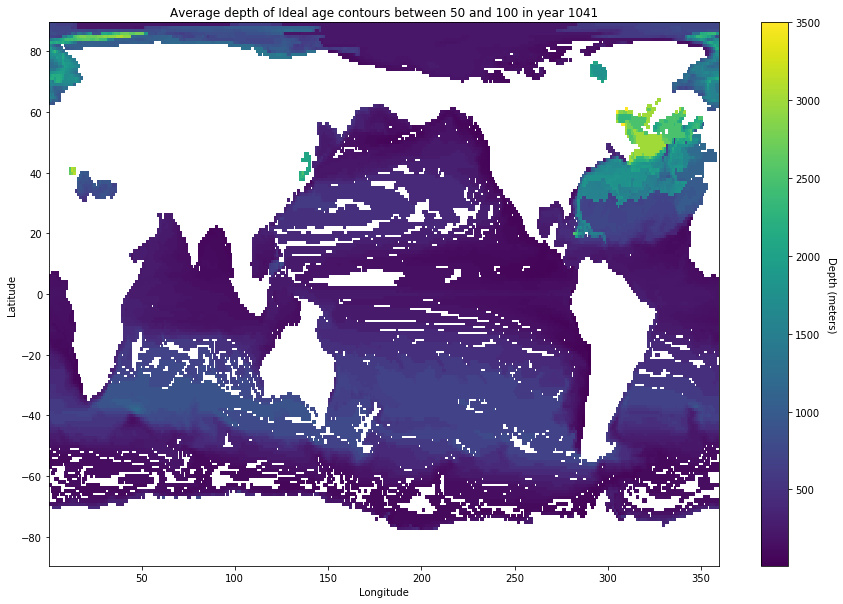

In [26]:
depthageplots(plotting, volle, deptharray, 50, 100)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


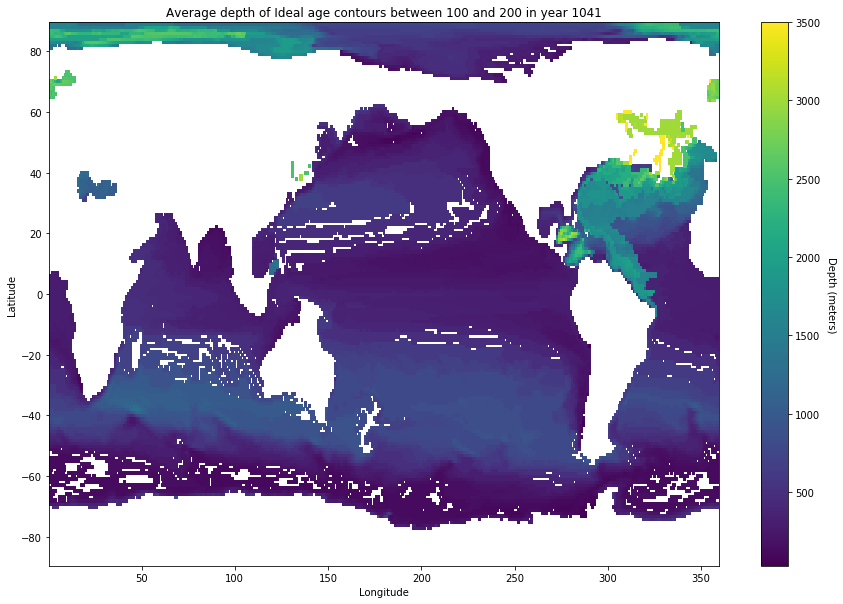

In [27]:
depthageplots(plotting, volle, deptharray, 100, 200)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


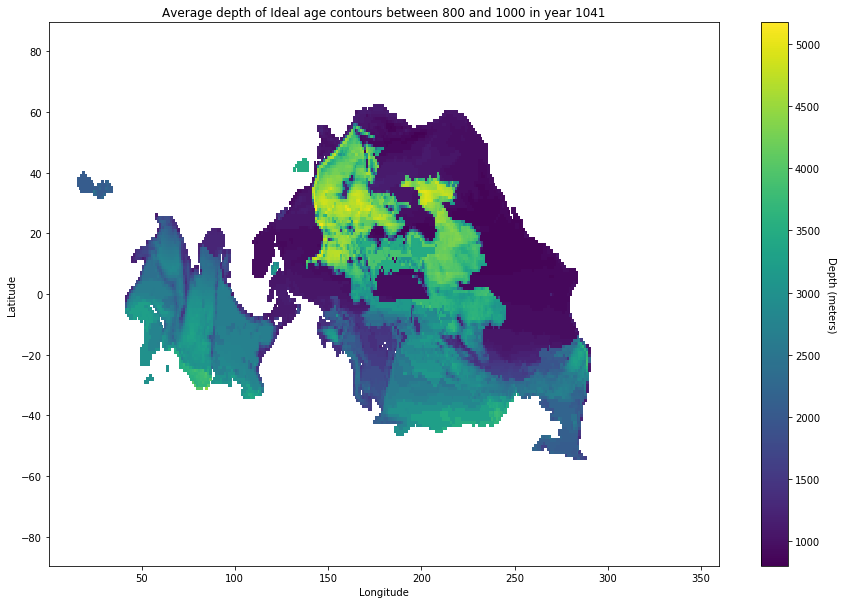

In [28]:
depthageplots(plotting, volle, deptharray, 800, 1000)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


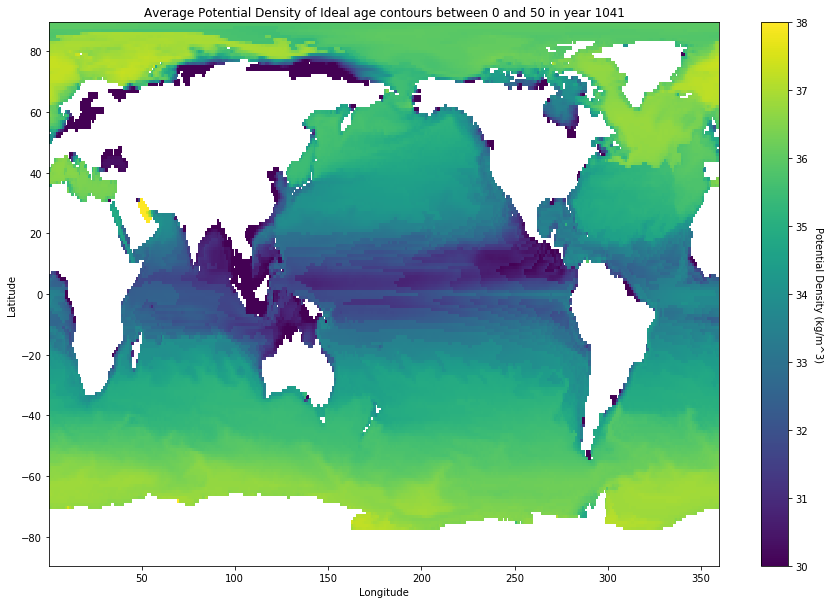

In [29]:
# Let's compare age and potential density

potdenarray = np.array(ds.potential_density.isel(time= 0))
def denageplots(age, volume, potden, val, val2, property, lo, hi):
    potdenplot = np.full([180, 360], 0)
    volplot = np.full([180, 360], 0)
    for i in range(0, 35):
        for j in range(0, 180):
            for k in range(0, 360):
                a = age[i][j][k]
                b = volume[i][j][k]
                if (a < val2 and a > val):
                    potdenplot[j][k] += potden[i][j][k]*b
                    volplot[j][k] += b
    # Let's see if this works
    refplot = potdenplot/volplot
    plt.figure(figsize = (15,10))
    im = plt.pcolormesh(lon, lat, refplot)
    im.set_clim([lo, hi])
    cbar = plt.colorbar(im)
    cbar.set_label( property + ' (kg/m^3)', rotation = 270, labelpad=16)
    plt.title('Average ' + property + ' of Ideal age contours between ' + str(val) + ' and ' + str(val2) + ' in year 1041')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
denageplots(plotting, volle, potdenarray, 0, 50, 'Potential Density', 30, 38)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


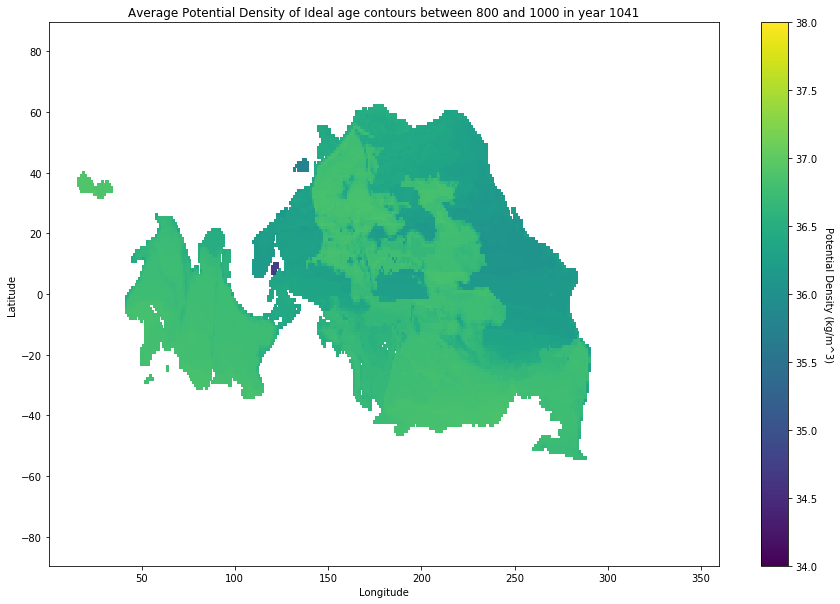

In [30]:
denageplots(plotting, volle, potdenarray, 800, 1000, 'Potential Density', 34, 38)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


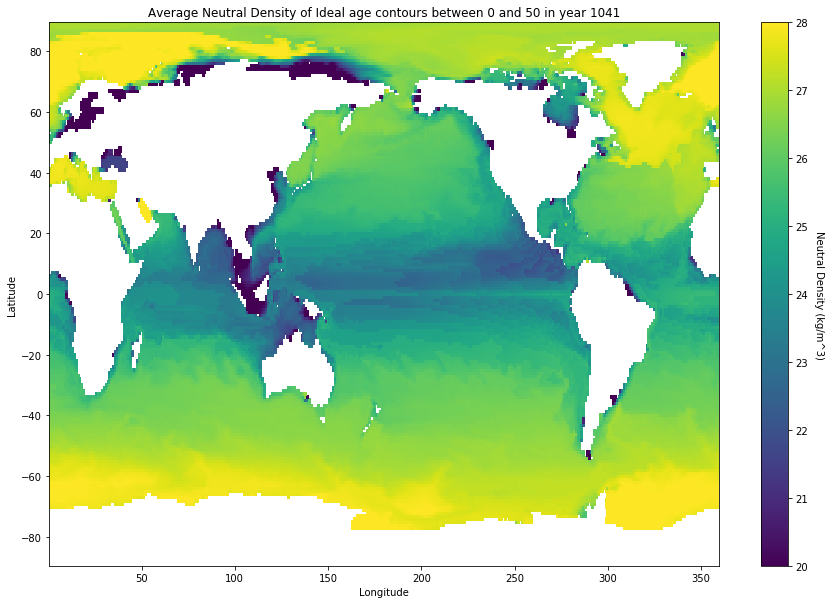

In [31]:
neutraldenarray = np.array(ds.neutral_density.isel(time= 0))
denageplots(plotting, volle, neutraldenarray, 0, 50, 'Neutral Density', 20, 28)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


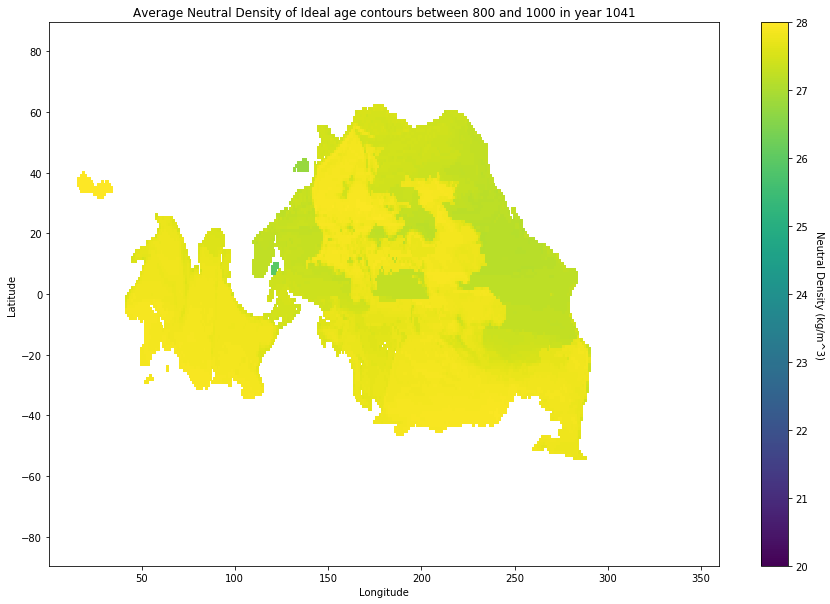

In [32]:
denageplots(plotting, volle, neutraldenarray, 800, 1000, 'Neutral Density', 20, 28)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


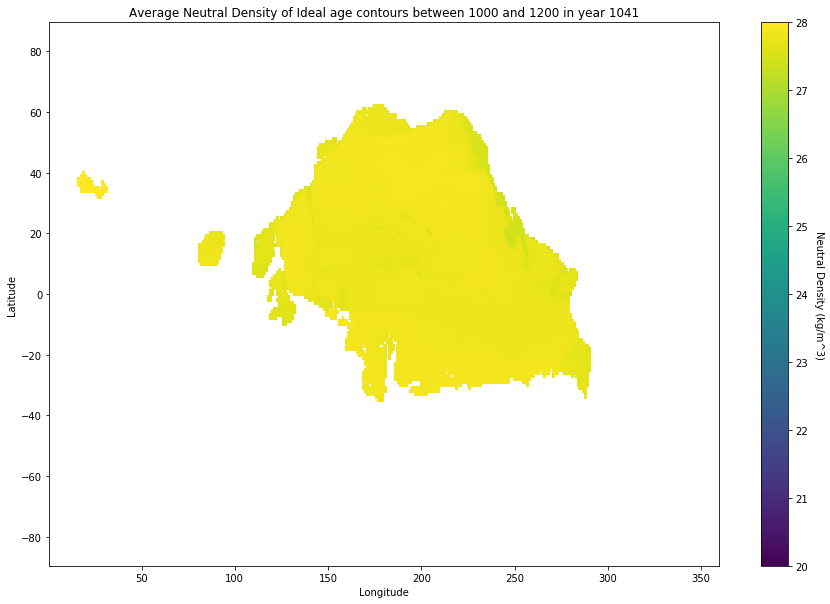

In [33]:
denageplots(plotting, volle, neutraldenarray, 1000, 1200, 'Neutral Density', 20, 28)